# Autograd

- autograd패키지는 텐서의 모든 연산에 대한 자동 미분을 제공
- 실행-기반-정의(define-by-run) 프레임워크로, 코드를 어떻게 작성하여 실행하느냐에 따라 역전파가 정의된다는 것을 의미
- 역전파는 학습 과정의 매 단계마다 달라짐

# Tensor

- torch.Tensor 클래스의 .requires_grad 속성을 True로 설정시 해당 텐서에서 이루어진 모든 연산을 추적(왜 추적을 하는거임? 역전파 계산을 위해?)
- 계산이 완료된 후 .backward()를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있으며 이 Tensor의 변화도는 .grad 속성에 누적됨(누적이 된다는게 값을 저장한다는 의미인가?)
- Tensor가 기록을 추적하는 것을 중단하게 하려면, .detach()를 호출하여 연산기록으로부터 분리하여 연산이 추적되는 것을 방지할 수 있음
- 기록 추적 방지(메모리 아끼기)하기 위해서 코드 블럭을 with torch.no_grad():로 감쌀 수 있음
- 변화도(gradient)는 필요 없지만 requires_grad=True가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가할 때 좋다
- Autograd 구현에서 Function 클래스는 매우 중요한 역할임
- Tensor와 Function은 서로 연결되어 있고 모든 연산 과정을 부호화하여 순환하지 않는 그래프를 생성
- 각 tensor는 .grad_fn 속성을 가지고 있는데 이는 Tensor를 생성한 Function을 참조함(grad_fn도 몰겠다)
- 도함수를 계산하기 위해서는 Tensor의 .backward()를 호출하면 됨
#### Q. bakcward = 역전파인데,   .grad?  grad_fn=grad function?

In [1]:
import torch

print(torch.__version__)

1.12.1


In [2]:
# x의 연산 과적을 추적하기 위해 requires_grad=True로 설정
x = torch.ones(2, 2, requires_grad=True)
print(x)

# 직접 생선한 Tensor이기 때문에 grad_fn이 None인 것을 확인할 수 있음
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [3]:
# y는 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖고 있는 것을 확인 가능
# 근데 grad_fn이 뭐여?

y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [4]:
z = y * y * 3
out = z.mean()

# 각각 사용한 func에 맞게 grad_fn이 생성된 것을 확인할 수 있음
print(z)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
tensor(27., grad_fn=<MeanBackward0>)


- requires_grad_()를 사용하면 기존 Tensor의 requires_grad 값을 바꿀 수 있음

- require_grad가 뭔디..

- 입력 값이 지정되지 않으면 기본 값은 False

In [5]:
a = torch.randn(2, 2)
print(a)

tensor([[ 1.0761, -1.0957],
        [ 1.5382, -0.7957]])


In [6]:
a = ((a * 3) / (a - 1))
print(a)
print(a.requires_grad)

tensor([[42.4470,  1.5685],
        [ 8.5743,  1.3294]])
False


In [7]:
a.requires_grad_(True)

tensor([[42.4470,  1.5685],
        [ 8.5743,  1.3294]], requires_grad=True)

In [8]:
print(a.requires_grad)


True


In [9]:
b = (a * a).sum()
print(b)
print(b.requires_grad)


tensor(1879.4906, grad_fn=<SumBackward0>)
True


# 변화도(Gradient)

In [10]:
print(out)

# 이전에 만든 out을 사용해서 역전파 진행

y.retain_grad()     # 중간 값에 대한 미분 값을 보고싶다면 해당 값에 대한 retain_grad()를 호출해야 함
z.retain_grad()
out.backward()      # 여러 번 미분을 진행하기 위해서는 retain_graph=True로 설정해줘야 함(그렇지 않으면 아래처럼 에러 발생)

# out.backward(torch.tensor(1.))을 진행하는 것과 동일
print(x.grad)
print(y.grad)
print(z.grad)
print(z.is_leaf) # 리프 노드인지 아닌지??

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])
False


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [11]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()

print(out)

y.retain_grad()
out.backward(retain_graph=True)

print(x.grad)
print(y.grad)
print(z.grad)       # z.retain_grad()를 호출하지 않으면 grad값을 저장하지 않기 때문에 grad 속성을 볼 수 없음
print(z.is_leaf)

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
None
False
tensor([[9., 9.],
        [9., 9.]])
tensor([[9., 9.],
        [9., 9.]])


/Users/KBS/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484744261/work/build/aten/src/ATen/core/TensorBody.h:482.)
  return self._grad


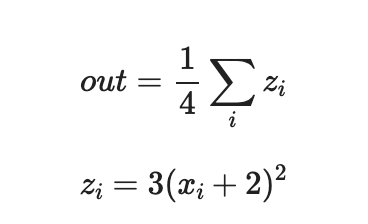

z_i를 미분한 값에 적용하면 4.5를 동일하게 출력할 수 있음


out(미분결과) = 1/4 6 (x + 2) = 3/2(x+2)



- 일반적으로 torch.autograd는 벡터-야코비안 곱을 계산하는 엔진
- torch.autograd를 사용하면 전체 야코비안을 직접 계산할 수는 없지만, 벡터-야코비안 곱은 backward에 해당 벡터를 인자로 제공하여 얻을 수 있

In [12]:
x = torch.randn(3, requires_grad=True)

y = x * 2

while y.data.norm() < 1000:
  y = y * 2

print(y)

tensor([ -773.1689, -1078.3737,   -82.3232], grad_fn=<MulBackward0>)


In [13]:
# scalar값이 아닌 y의 벡터-야코비안 곱을 구하는 과정..
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


- with torch.no_grad()로 코드 블록을 감싸서 autograd가 .requires_grad=True인 Tensor의 연산 기록을 추적하는 것을 멈출 수도 있음!


In [14]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
  print((x ** 2).requires_grad)

True
True
False


또는 .detach()를 호출하여 내용물은 같지만 requires_grad가 다른 새로운 텐서를 가져올 수 있다.
값들은 동일하지만 속성값만 다르다는 점.
- 중요한점 : 넘파이는 모든 미분하는 과정들을 사용자가 수기로 작성해야하지만 오토그래드는 미분이 자동으로 이루어진다는 점.


In [15]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


# ANN(Artificial Neural Networks)


- 신경망은 torch.nn 패키지를 사용하여 생성할 수 있음  
- nn은 모델을 정의하고 미분하기 위해서 위에서 살펴본 autograd를 사용
- nn.Module은 계층(layer)과 output을 반환하는 forward(input) 메소드를 포함
- 그리고 간단한 순전파 네트워크(feed-forward-network)

신경망의 일반적인 학습 과정

1. 학습 가능한 매개변수(가중치)를 갖는 신경망을 정의
2. 데이터 셋 입력을 반복
3. 입력을 신경망에서 전파(process)
4. 손실(loss; 입력 값과 예측 값과의 차이)를 계산
5. 변화도(gradient)를 신경망의 매개변수들에 역으로 전파 - 역전파 과정
6. 신경망의 가중치를 갱신
    ### 새로운 가중치(weight) = 가중치(weight) - 학습률(learning rate) * 변화도(gradient)

In [16]:
import pandas as pd

from sklearn.datasets import load_iris

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [17]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128) # 선형함수
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128) #정규화해주는 효과
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU() # 비선형함수 렐루

    def forward(self, x):
      x = self.act(self.bn0(self.layer0(x)))
      x = self.act(self.bn1(self.layer1(x)))
      x = self.act(self.bn2(self.layer2(x)))
      x = self.act(self.layer3(x))
      x = self.layer4(x)

      return x

# 손실 함수(Loss Function)


- 손실 함수는 (output, target)을 한 쌍으로 입력 받아, 출력이 정답으로부터 얼마나 떨어져있는지 추정하는 값을 계산
- forward함수만 정의하고 나면 backward함수는 autograd를 사용하여 자동으로 정의됨
- 모델의 학습 가능한 매개 변수는 net.parameters()에 의해 변환됨


In [20]:
# CrossEntropyLoss : 다중 분류 문제에서 사용 됨 
# 랜덤 값 생성
criterion = nn.CrossEntropyLoss()

ex_X, ex_y = torch.randn([4, 4]), torch.tensor([1, 0, 2, 0])


net = Net() # net 모델 정의
output = net(ex_X) #입력값이 네트워클르 통과한 예측값
loss = criterion(output, ex_y) # 예측값과 정닶값 차이 =로스
print('loss: ', loss.item())
  
net.zero_grad()

print('layer0.bias.grad before backward')
print(net.layer4.bias.grad)

print(net.layer4.bias.is_leaf)

loss.backward()

print('layer0.bias.grad after backward')
print(net.layer4.bias.grad)

loss:  1.0356696844100952
layer0.bias.grad before backward
None
True
layer0.bias.grad after backward
tensor([-0.1614,  0.1061,  0.0553])


어떤 경우가 leaf 노드가 뭐자???? https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20
왜 leaf 노드인 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지??? - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7

In [21]:
params = list(net.parameters()) #각각의 층에 바이어스, 가중치 값이 들어있기 떄문에 2배?
print(len(params))
print(params[0].size())  # layer0의 weight

16
torch.Size([128, 4])


# 가중치 갱신


- 가장 단순한 갱신 규칙은 확률적 경사하강법(SGD; Stochastic Gradient Descent)

### W(news가중치) = W - LR * Grad

In [25]:
# torch.optim 패키지에 다양한 갱신 규칙이 규현되어 있음

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001) #갱신규칙설정

optimizer.zero_grad() #0초기화
output = net(ex_X) # 에측값구하기
loss = criterion(output, ex_y) #로스구하기
loss.backward() #로스 역전파 진행
optimizer.step()  # 업데이트 진행

# 아이리스 데이터로 직접 MLP 모델만들어보기!!!

In [24]:
dataset = load_iris()

data = dataset.data
label = dataset.target

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [26]:
print('shape of data: ', data.shape)
print('shape of label: ',label.shape) # 인스턴스당 하나의 라벨값??이 무슨말인지.

shape of data:  (150, 4)
shape of label:  (150,)


# 1. 훈련과 테스트 데이터로 나누기

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
print(len(X_train))
print(len(X_test))

112
38


# 2. DataLoader 생성

In [28]:

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_set = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True) # 배치사이즈? 한 번에 몇 개 데이터 볼것인지...4개의 데이터를 한 번에 신경망에 넣는다는 뜻

In [30]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001) #옵티마이저 설정
criterion = nn.CrossEntropyLoss() # 로스값 설정
epochs = 200 # 몇번을 반복할지?

## epochs가 뭔지 알려주라..

In [31]:

losses = list()
accuracies = list()

for epoch in range(epochs):
  epoch_loss = 0                   #epochs 로스와 accruacy를 구하는 이유가 뭘까??..
  epoch_accuracy = 0
  for X, y in train_loader:
  
    optimizer.zero_grad() # gred 0 초기화
    
    output = net(X) # d예측값 초기화

    loss = criterion(output, y) # 오차구하기 
    loss.backward() # 오차 사용해서 역전파진행
    
    optimizer.step() # 업데이트
    # output = [0.11, 0.5, 0.8]  --> 모델이 예측한 클래스 값, 예측한 0.8이 라벨값
    _, predicted = torch.max(output, dim=1)
    accuracy = (predicted == y).sum().item()
    epoch_loss += loss.item()
    epoch_accuracy += accuracy
  

  epoch_loss /= len(train_loader)
  epoch_accuracy /= len(X_train)
  print("epoch :{}, \tloss :{}, \taccuracy :{}".format(str(epoch+1).zfill(3),round(epoch_loss,4), round(epoch_accuracy,4)))
  
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

epoch :001, 	loss :1.0801, 	accuracy :0.4286
epoch :002, 	loss :1.0574, 	accuracy :0.4375
epoch :003, 	loss :1.0606, 	accuracy :0.4554
epoch :004, 	loss :1.0398, 	accuracy :0.5536
epoch :005, 	loss :1.0236, 	accuracy :0.5357
epoch :006, 	loss :1.0113, 	accuracy :0.5625
epoch :007, 	loss :1.0194, 	accuracy :0.5536
epoch :008, 	loss :1.0121, 	accuracy :0.5179
epoch :009, 	loss :0.9832, 	accuracy :0.5536
epoch :010, 	loss :0.9902, 	accuracy :0.5893
epoch :011, 	loss :0.9897, 	accuracy :0.5268
epoch :012, 	loss :0.9924, 	accuracy :0.5446
epoch :013, 	loss :1.0129, 	accuracy :0.4911
epoch :014, 	loss :0.9491, 	accuracy :0.5982
epoch :015, 	loss :0.9619, 	accuracy :0.5714
epoch :016, 	loss :0.9548, 	accuracy :0.5268
epoch :017, 	loss :0.9411, 	accuracy :0.5625
epoch :018, 	loss :0.9575, 	accuracy :0.5179
epoch :019, 	loss :0.946, 	accuracy :0.5714
epoch :020, 	loss :0.9463, 	accuracy :0.5446
epoch :021, 	loss :0.9361, 	accuracy :0.5714
epoch :022, 	loss :0.9316, 	accuracy :0.5268
epoch :023,

epoch :187, 	loss :0.3886, 	accuracy :0.8839
epoch :188, 	loss :0.4322, 	accuracy :0.8393
epoch :189, 	loss :0.498, 	accuracy :0.8304
epoch :190, 	loss :0.4321, 	accuracy :0.8571
epoch :191, 	loss :0.475, 	accuracy :0.8304
epoch :192, 	loss :0.3717, 	accuracy :0.9196
epoch :193, 	loss :0.4427, 	accuracy :0.8214
epoch :194, 	loss :0.564, 	accuracy :0.75
epoch :195, 	loss :0.414, 	accuracy :0.8571
epoch :196, 	loss :0.5037, 	accuracy :0.8125
epoch :197, 	loss :0.4723, 	accuracy :0.8482
epoch :198, 	loss :0.3664, 	accuracy :0.875
epoch :199, 	loss :0.4496, 	accuracy :0.8571
epoch :200, 	loss :0.4349, 	accuracy :0.8661


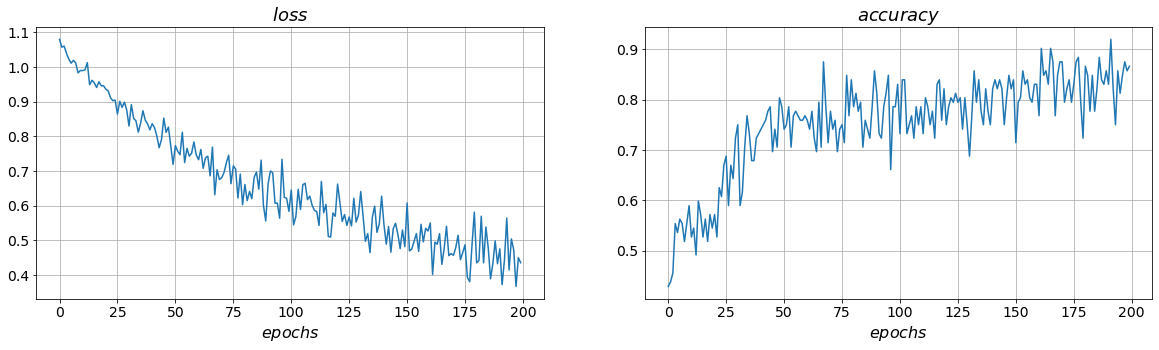

In [32]:
# Plot result

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title("$loss$",fontsize = 18)
plt.plot(losses)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


plt.subplot(1,2,2)
plt.title("$accuracy$", fontsize = 18)
plt.plot(accuracies)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

# 로스와 정확도 모두 왔다갔다 한다..단순모델이라서 복잡한 형태는 못 잡음?
# 테스트 데이터로 진짜 해보자.

In [36]:
# Test

output = net(X_test) # 모델에 다가 테스트데이터셋 넣고



In [37]:
print(torch.max(output, dim=1))
_, predicted = torch.max(output, dim=1) # 예측값을 뽑고?

accuracy = round((predicted == y_test).sum().item() / len(y_test),4)


print("test_set accuracy :", round(accuracy,4))

torch.return_types.max(
values=tensor([1.7841, 2.0662, 3.4004, 2.5396, 1.2433, 1.4121, 1.2811, 1.0529, 1.4158,
        1.9177, 3.0429, 1.0067, 1.3079, 1.6042, 0.7854, 1.2641, 2.5384, 1.7967,
        2.2657, 1.8087, 1.4726, 0.7063, 1.5270, 2.0147, 1.8985, 1.7085, 1.4289,
        1.7871, 0.4635, 2.3471, 2.8357, 2.6877, 1.4047, 1.8026, 1.3856, 1.6997,
        1.1583, 2.1823], grad_fn=<MaxBackward0>),
indices=tensor([2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 1, 0,
        1, 2, 0, 1, 1, 0, 0, 2, 0, 0, 1, 0, 1, 2]))
test_set accuracy : 0.9737


In [38]:
# 정확도 97,,,아마 데이터셋이 작아서 그런건가??